[![Roboflow Notebooks](https://ik.imagekit.io/roboflow/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# RTMDet with MMDetection and MMYOLO

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/open-mmlab/mmdetection)
[![arXiv](https://img.shields.io/badge/arXiv-2212.07784-b31b1b.svg)](https://arxiv.org/pdf/2212.07784.pdf)

![Models Comparison](https://user-images.githubusercontent.com/17425982/222087414-168175cc-dae6-4c5c-a8e3-3109a152dd19.png)

***Figure 1.*** *RTMDet vs. other real-time object detectors.*

![Model Structure](https://user-images.githubusercontent.com/27466624/204126145-cb4ff4f1-fb16-455e-96b5-17620081023a.jpg)

***Figure 2.*** *RTMDet-l model structure.*

## Steps in this Tutorial

- Before you start
- Install MMDetection and MMYOLO
- Inference with pre-trained RTMDet COCO model
- Finding open source datasets
- ⭐️ Training RTMDet on your custom dataset ⭐️
- Load trained model
- Inference with trained model
- Use `supervision` to evaluate trained RTMDet model

## Let's begin! 🔥

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Fri Aug  4 12:38:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [3]:
!gcc --version

gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [4]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Install MMDetection and MMYOLO

**NOTE:** MMYOLO relies on PyTorch, MMCV, MMEngine, and MMDetection. Below are quick steps for installation. Please refer to the [Install Guide](https://github.com/open-mmlab/mmyolo/blob/main/docs/en/get_started/installation.md) for more detailed instructions.

In [ ]:
%cd {HOME}

%pip install -U -q openmim

!mim install -q "mmengine>=0.6.0"
!mim install -q "mmcv>=2.0.0rc4,<2.1.0"
!mim install -q "mmdet>=3.0.0rc6,<3.1.0"

!git clone https://github.com/open-mmlab/mmyolo.git

%cd {HOME}/mmyolo

%pip install -e .

**NOTE:** Install additional packages:
- [roboflow](https://github.com/roboflow/roboflow) - open-source datasets
- [supervision](https://github.com/roboflow/supervision) - computer vision utilities

In [ ]:
!pip install -q roboflow
!pip install -q supervision==0.12.0

## Imports

In [34]:
import cv2
import os
import json
import roboflow
import torch
import random
import supervision as sv
import numpy as np

from mmdet.apis import init_detector, inference_detector

## Inference with pre-trained RTMDet COCO model

### Download weights

Start by instantiating a pretrained model. RTMDet architecture comes in five different sizes: `RTMDet-t`, `RTMDet-s`, `RTMDet-m`, `RTMDet-l`, and `RTMDet-x`. We will use `RTMDet-l` throughout this notebook. Keep in mind that depending on your use-case your decision may be different. Take a peek at the diagram below visualizing the speed-accuracy tradeoff.

<br>

| Model | Size | Params(M) | FLOPs(G) | TRT-FP16-Latency(ms) | box AP | TTA box AP | Config | Download |
|:-----:|:----:|:---------:|:--------:|:--------------------:|:------:|:----------:|:------:|:--------:|
|  RTMDet-tiny   | 640  |    4.8    |   8.1    |         0.98         |    41.0     |    42.7     |   [config](https://github.com/open-mmlab/mmyolo/edit/main/configs/rtmdet/rtmdet_tiny_syncbn_fast_8xb32-300e_coco.py)    | [model](https://download.openmmlab.com/mmyolo/v0/rtmdet/rtmdet_tiny_syncbn_fast_8xb32-300e_coco/rtmdet_tiny_syncbn_fast_8xb32-300e_coco_20230102_140117-dbb1dc83.pth) \| [log](https://download.openmmlab.com/mmyolo/v0/rtmdet/rtmdet_tiny_syncbn_fast_8xb32-300e_coco/rtmdet_tiny_syncbn_fast_8xb32-300e_coco_20230102_140117.log.json)  |
| RTMDet-tiny \* | 640  |    4.8    |   8.1    |         0.98         | 41.8 (+0.8) | 43.2 (+0.5) | [config](https://github.com/open-mmlab/mmyolo/edit/main/configs/rtmdet/distillation/kd_tiny_rtmdet_s_neck_300e_coco.py) | [model](https://download.openmmlab.com/mmrazor/v1/rtmdet_distillation/kd_tiny_rtmdet_s_neck_300e_coco/kd_tiny_rtmdet_s_neck_300e_coco_20230213_104240-e1e4197c.pth) \| [log](https://download.openmmlab.com/mmrazor/v1/rtmdet_distillation/kd_tiny_rtmdet_s_neck_300e_coco/kd_tiny_rtmdet_s_neck_300e_coco_20230213_104240-176901d8.json) |
|    RTMDet-s    | 640  |   8.89    |   14.8   |         1.22         |    44.6     |    45.8     |     [config](https://github.com/open-mmlab/mmyolo/edit/main/configs/rtmdet/rtmdet_s_syncbn_fast_8xb32-300e_coco.py)     |       [model](https://download.openmmlab.com/mmyolo/v0/rtmdet/rtmdet_s_syncbn_fast_8xb32-300e_coco/rtmdet_s_syncbn_fast_8xb32-300e_coco_20221230_182329-0a8c901a.pth) \| [log](https://download.openmmlab.com/mmyolo/v0/rtmdet/rtmdet_s_syncbn_fast_8xb32-300e_coco/rtmdet_s_syncbn_fast_8xb32-300e_coco_20221230_182329.log.json)        |
|  RTMDet-s \*   | 640  |   8.89    |   14.8   |         1.22         | 45.7 (+1.1) | 47.3 (+1.5) |  [config](https://github.com/open-mmlab/mmyolo/edit/main/configs/rtmdet/distillation/kd_s_rtmdet_m_neck_300e_coco.py)   |       [model](https://download.openmmlab.com/mmrazor/v1/rtmdet_distillation/kd_s_rtmdet_m_neck_300e_coco/kd_s_rtmdet_m_neck_300e_coco_20230220_140647-446ff003.pth) \| [log](https://download.openmmlab.com/mmrazor/v1/rtmdet_distillation/kd_s_rtmdet_m_neck_300e_coco/kd_s_rtmdet_m_neck_300e_coco_20230220_140647-89862269.json)       |
|    RTMDet-m    | 640  |   24.71   |  39.27   |         1.62         |    49.3     |    50.9     |     [config](https://github.com/open-mmlab/mmyolo/edit/main/configs/rtmdet/rtmdet_m_syncbn_fast_8xb32-300e_coco.py)     |       [model](https://download.openmmlab.com/mmyolo/v0/rtmdet/rtmdet_m_syncbn_fast_8xb32-300e_coco/rtmdet_m_syncbn_fast_8xb32-300e_coco_20230102_135952-40af4fe8.pth) \| [log](https://download.openmmlab.com/mmyolo/v0/rtmdet/rtmdet_m_syncbn_fast_8xb32-300e_coco/rtmdet_m_syncbn_fast_8xb32-300e_coco_20230102_135952.log.json)        |
|  RTMDet-m \*   | 640  |   24.71   |  39.27   |         1.62         | 50.2 (+0.9) | 51.9 (+1.0) |  [config](https://github.com/open-mmlab/mmyolo/edit/main/configs/rtmdet/distillation/kd_m_rtmdet_l_neck_300e_coco.py)   |       [model](https://download.openmmlab.com/mmrazor/v1/rtmdet_distillation/kd_m_rtmdet_l_neck_300e_coco/kd_m_rtmdet_l_neck_300e_coco_20230220_141313-b806f503.pth) \| [log](https://download.openmmlab.com/mmrazor/v1/rtmdet_distillation/kd_m_rtmdet_l_neck_300e_coco/kd_m_rtmdet_l_neck_300e_coco_20230220_141313-bd028fd3.json)       |
|    RTMDet-l    | 640  |   52.3    |  80.23   |         2.44         |    51.4     |    53.1     |     [config](https://github.com/open-mmlab/mmyolo/edit/main/configs/rtmdet/rtmdet_l_syncbn_fast_8xb32-300e_coco.py)     |       [model](https://download.openmmlab.com/mmyolo/v0/rtmdet/rtmdet_l_syncbn_fast_8xb32-300e_coco/rtmdet_l_syncbn_fast_8xb32-300e_coco_20230102_135928-ee3abdc4.pth) \| [log](https://download.openmmlab.com/mmyolo/v0/rtmdet/rtmdet_l_syncbn_fast_8xb32-300e_coco/rtmdet_l_syncbn_fast_8xb32-300e_coco_20230102_135928.log.json)        |
|  RTMDet-l \*   | 640  |   52.3    |  80.23   |         2.44         | 52.3 (+0.9) | 53.7 (+0.6) |  [config](https://github.com/open-mmlab/mmyolo/edit/main/configs/rtmdet/distillation/kd_l_rtmdet_x_neck_300e_coco.py)   |       [model](https://download.openmmlab.com/mmrazor/v1/rtmdet_distillation/kd_l_rtmdet_x_neck_300e_coco/kd_l_rtmdet_x_neck_300e_coco_20230220_141912-c9979722.pth) \| [log](https://download.openmmlab.com/mmrazor/v1/rtmdet_distillation/kd_l_rtmdet_x_neck_300e_coco/kd_l_rtmdet_x_neck_300e_coco_20230220_141912-c5c4e17b.json)       |
|    RTMDet-x    | 640  |   94.86   |  141.67  |         3.10         |    52.8     |    54.2     |     [config](https://github.com/open-mmlab/mmyolo/edit/main/configs/rtmdet/rtmdet_x_syncbn_fast_8xb32-300e_coco.py)     |       [model](https://download.openmmlab.com/mmyolo/v0/rtmdet/rtmdet_x_syncbn_fast_8xb32-300e_coco/rtmdet_x_syncbn_fast_8xb32-300e_coco_20221231_100345-b85cd476.pth) \| [log](https://download.openmmlab.com/mmyolo/v0/rtmdet/rtmdet_x_syncbn_fast_8xb32-300e_coco/rtmdet_x_syncbn_fast_8xb32-300e_coco_20221231_100345.log.json)        |


In [8]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://download.openmmlab.com/mmyolo/v0/rtmdet/rtmdet_l_syncbn_fast_8xb32-300e_coco/rtmdet_l_syncbn_fast_8xb32-300e_coco_20230102_135928-ee3abdc4.pth
!ls -lh {HOME}/weights

total 201M
-rw-r--r-- 1 root root 201M Jan  4  2023 rtmdet_l_syncbn_fast_8xb32-300e_coco_20230102_135928-ee3abdc4.pth


### Download example data

**NONE:** Let's download few example images. Feel free to use your images or videos.

In [9]:
!mkdir -p {HOME}/data
!wget -P {HOME}/data -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!ls -lh {HOME}/data

total 104K
-rw-r--r-- 1 root root 104K Jun  2 16:01 dog.jpeg


### Configuration

In [10]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CONFIG_PATH = f"{HOME}/mmyolo/configs/rtmdet/rtmdet_l_syncbn_fast_8xb32-300e_coco.py"
WEIGHTS_PATH = f"{HOME}/weights/rtmdet_l_syncbn_fast_8xb32-300e_coco_20230102_135928-ee3abdc4.pth"

### Load model

In [11]:
model = init_detector(CONFIG_PATH, WEIGHTS_PATH, device=DEVICE)

Loads checkpoint by local backend from path: /content/weights/rtmdet_l_syncbn_fast_8xb32-300e_coco_20230102_135928-ee3abdc4.pth


### Inference

In [12]:
IMAGE_PATH = f"{HOME}/data/dog.jpeg"

In [13]:
image = cv2.imread(IMAGE_PATH)
result = inference_detector(model, image)

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)


**NOTE:** Let's use `supervision` to  detections.

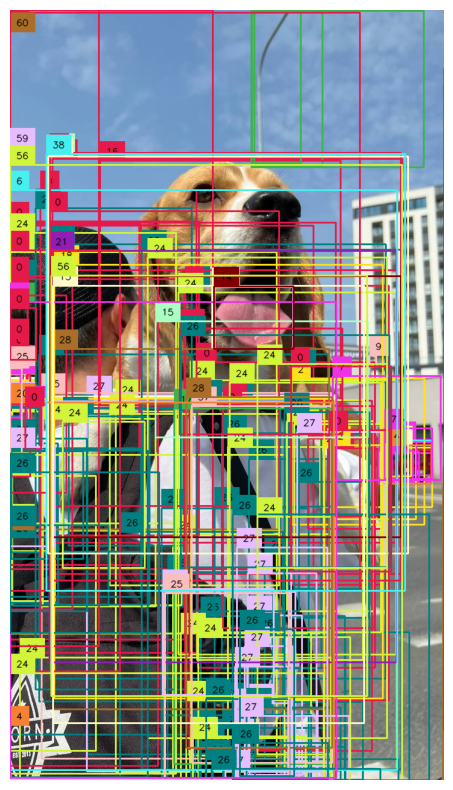

In [14]:
detections = sv.Detections.from_mmdetection(result)
box_annotator = sv.BoxAnnotator()
annotated_image = box_annotator.annotate(image.copy(), detections)
sv.plot_image(image=annotated_image, size=(10, 10))

**NOTE:** Let's filter out detections with low probability. We can use the detection filtering available in `supervision`.

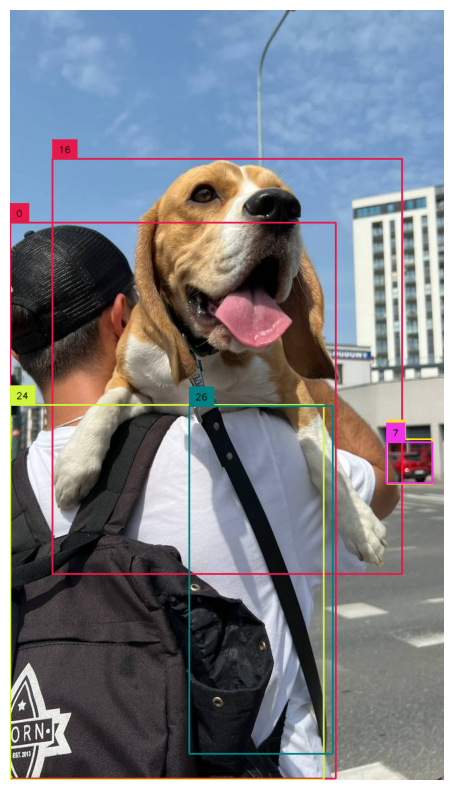

In [15]:
detections = detections[detections.confidence > 0.3].with_nms()
box_annotator = sv.BoxAnnotator()
annotated_image = box_annotator.annotate(image.copy(), detections)
sv.plot_image(image=annotated_image, size=(10, 10))

## Finding open source datasets

**NOTE:** Let's create `data` directory and save our dataset there.

In [16]:
!mkdir -p {HOME}/mmyolo/data
%cd {HOME}/mmyolo/data

/content/mmyolo/data


In [17]:
roboflow.login()

rf = roboflow.Roboflow()

project = rf.workspace("roboflow-jvuqo").project("football-players-detection-3blva")
dataset = project.version(1).download("coco")

visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Football-Players-Detection-1 in coco:: 100%|██████████| 1123/1123 [00:00<00:00, 4470.69it/s]


### Postprocess

**NOTE:** We downloaded our dataset from [Roboflow Universe](https://universe.roboflow.com/). Although the dataset is in COCO format we need to make a few minor changes to its format so that it can be used to train the model using the MMDetection library. LEt's run the code below to do that.

In [18]:
def load_json(path: str) -> dict:
    with open(path, 'r') as file:
        data = json.load(file)
    return data

def drop_supercategories(data: dict) -> dict:
    data['categories'] = [
        category
        for category
        in data['categories']
        if category['supercategory'] != 'none'
    ]
    return data

def save_json(data: json, path: str):
    with open(path, 'w') as file:
        json.dump(data, file, indent=4)

def process_annotations(path: str) -> None:
    data = load_json(path=path)
    data = drop_supercategories(data=data)
    save_json(data=data, path=path)

def process_roboflow_annotations(dataset_path: str) -> None:
    subsets = ['train', 'test', 'valid']
    for subset in subsets:
        annotations_path = os.path.join(dataset_path, subset, '_annotations.coco.json')
        if os.path.exists(annotations_path):
            process_annotations(annotations_path)

In [20]:
process_roboflow_annotations(dataset_path=dataset.location)

## Training RTMDet on your custom dataset

### Configuration

**NOTE:** MMDetection uses configuration files to store information about the model's input resolution, the number of training epochs, learning rate and also the dataset on which we want to train our model. These files are often quite verose but don't worry about it.

The file below was created based on the [configuration file](https://github.com/open-mmlab/mmyolo/blob/main/configs/rtmdet/rtmdet_l_syncbn_fast_8xb32-300e_coco.py) for the RTMDet-L model. Usually the best strategy is to copy the input file and make your changes to it.

In [27]:
BATCH_SIZE = 8
MAX_EPOCHS = 50

In [28]:
CUSTOM_CONFIG_PATH = f"{HOME}/mmyolo/configs/rtmdet/custom.py"

CUSTOM_CONFIG = f"""
_base_ = ['../_base_/default_runtime.py', '../_base_/det_p5_tta.py']

# ========================Frequently modified parameters======================
# -----data related-----
data_root = '{dataset.location}/'

train_ann_file = 'train/_annotations.coco.json'
train_data_prefix = 'train/'

val_ann_file = 'valid/_annotations.coco.json'
val_data_prefix = 'valid/'

class_name = {tuple(sorted(project.classes.keys()))}
num_classes = {len(project.classes)}

metainfo = dict(classes=class_name, palette=[(20, 220, 60)])

train_batch_size_per_gpu = {BATCH_SIZE}
# Worker to pre-fetch data for each single GPU during training
train_num_workers = 4
# persistent_workers must be False if num_workers is 0.
persistent_workers = True

# -----train val related-----
# Base learning rate for optim_wrapper. Corresponding to 8xb16=64 bs
base_lr = 0.004
max_epochs = {MAX_EPOCHS}  # Maximum training epochs
# Change train_pipeline for final 20 epochs (stage 2)
num_epochs_stage2 = 20

model_test_cfg = dict(
    # The config of multi-label for multi-class prediction.
    multi_label=True,
    # The number of boxes before NMS
    nms_pre=30000,
    score_thr=0.001,  # Threshold to filter out boxes.
    nms=dict(type='nms', iou_threshold=0.65),  # NMS type and threshold
    max_per_img=300)  # Max number of detections of each image

# ========================Possible modified parameters========================
# -----data related-----
img_scale = (640, 640)  # width, height
# ratio range for random resize
random_resize_ratio_range = (0.1, 2.0)
# Cached images number in mosaic
mosaic_max_cached_images = 40
# Number of cached images in mixup
mixup_max_cached_images = 20
# Dataset type, this will be used to define the dataset
dataset_type = 'YOLOv5CocoDataset'
# Batch size of a single GPU during validation
val_batch_size_per_gpu = 32
# Worker to pre-fetch data for each single GPU during validation
val_num_workers = 10

# Config of batch shapes. Only on val.
batch_shapes_cfg = dict(
    type='BatchShapePolicy',
    batch_size=val_batch_size_per_gpu,
    img_size=img_scale[0],
    size_divisor=32,
    extra_pad_ratio=0.5)

# -----model related-----
# The scaling factor that controls the depth of the network structure
deepen_factor = 1.0
# The scaling factor that controls the width of the network structure
widen_factor = 1.0
# Strides of multi-scale prior box
strides = [8, 16, 32]

norm_cfg = dict(type='BN')  # Normalization config

# -----train val related-----
lr_start_factor = 1.0e-5
dsl_topk = 13  # Number of bbox selected in each level
loss_cls_weight = 1.0
loss_bbox_weight = 2.0
qfl_beta = 2.0  # beta of QualityFocalLoss
weight_decay = 0.05

# Save model checkpoint and validation intervals
save_checkpoint_intervals = 10
# validation intervals in stage 2
val_interval_stage2 = 1
# The maximum checkpoints to keep.
max_keep_ckpts = 3
# single-scale training is recommended to
# be turned on, which can speed up training.
env_cfg = dict(cudnn_benchmark=True)

# ===============================Unmodified in most cases====================
model = dict(
    type='YOLODetector',
    data_preprocessor=dict(
        type='YOLOv5DetDataPreprocessor',
        mean=[103.53, 116.28, 123.675],
        std=[57.375, 57.12, 58.395],
        bgr_to_rgb=False),
    backbone=dict(
        type='CSPNeXt',
        arch='P5',
        expand_ratio=0.5,
        deepen_factor=deepen_factor,
        widen_factor=widen_factor,
        channel_attention=True,
        norm_cfg=norm_cfg,
        act_cfg=dict(type='SiLU', inplace=True)),
    neck=dict(
        type='CSPNeXtPAFPN',
        deepen_factor=deepen_factor,
        widen_factor=widen_factor,
        in_channels=[256, 512, 1024],
        out_channels=256,
        num_csp_blocks=3,
        expand_ratio=0.5,
        norm_cfg=norm_cfg,
        act_cfg=dict(type='SiLU', inplace=True)),
    bbox_head=dict(
        type='RTMDetHead',
        head_module=dict(
            type='RTMDetSepBNHeadModule',
            num_classes=num_classes,
            in_channels=256,
            stacked_convs=2,
            feat_channels=256,
            norm_cfg=norm_cfg,
            act_cfg=dict(type='SiLU', inplace=True),
            share_conv=True,
            pred_kernel_size=1,
            featmap_strides=strides),
        prior_generator=dict(
            type='mmdet.MlvlPointGenerator', offset=0, strides=strides),
        bbox_coder=dict(type='DistancePointBBoxCoder'),
        loss_cls=dict(
            type='mmdet.QualityFocalLoss',
            use_sigmoid=True,
            beta=qfl_beta,
            loss_weight=loss_cls_weight),
        loss_bbox=dict(type='mmdet.GIoULoss', loss_weight=loss_bbox_weight)),
    train_cfg=dict(
        assigner=dict(
            type='BatchDynamicSoftLabelAssigner',
            num_classes=num_classes,
            topk=dsl_topk,
            iou_calculator=dict(type='mmdet.BboxOverlaps2D')),
        allowed_border=-1,
        pos_weight=-1,
        debug=False),
    test_cfg=model_test_cfg,
)

train_pipeline = [
    dict(type='LoadImageFromFile', file_client_args=_base_.file_client_args),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(
        type='Mosaic',
        img_scale=img_scale,
        use_cached=True,
        max_cached_images=mosaic_max_cached_images,
        pad_val=114.0),
    dict(
        type='mmdet.RandomResize',
        # img_scale is (width, height)
        scale=(img_scale[0] * 2, img_scale[1] * 2),
        ratio_range=random_resize_ratio_range,
        resize_type='mmdet.Resize',
        keep_ratio=True),
    dict(type='mmdet.RandomCrop', crop_size=img_scale),
    dict(type='mmdet.YOLOXHSVRandomAug'),
    dict(type='mmdet.RandomFlip', prob=0.5),
    dict(type='mmdet.Pad', size=img_scale, pad_val=dict(img=(114, 114, 114))),
    dict(
        type='YOLOv5MixUp',
        use_cached=True,
        max_cached_images=mixup_max_cached_images),
    dict(type='mmdet.PackDetInputs')
]

train_pipeline_stage2 = [
    dict(type='LoadImageFromFile', file_client_args=_base_.file_client_args),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(
        type='mmdet.RandomResize',
        scale=img_scale,
        ratio_range=random_resize_ratio_range,
        resize_type='mmdet.Resize',
        keep_ratio=True),
    dict(type='mmdet.RandomCrop', crop_size=img_scale),
    dict(type='mmdet.YOLOXHSVRandomAug'),
    dict(type='mmdet.RandomFlip', prob=0.5),
    dict(type='mmdet.Pad', size=img_scale, pad_val=dict(img=(114, 114, 114))),
    dict(type='mmdet.PackDetInputs')
]

test_pipeline = [
    dict(type='LoadImageFromFile', file_client_args=_base_.file_client_args),
    dict(type='YOLOv5KeepRatioResize', scale=img_scale),
    dict(
        type='LetterResize',
        scale=img_scale,
        allow_scale_up=False,
        pad_val=dict(img=114)),
    dict(type='LoadAnnotations', with_bbox=True, _scope_='mmdet'),
    dict(
        type='mmdet.PackDetInputs',
        meta_keys=('img_id', 'img_path', 'ori_shape', 'img_shape',
                   'scale_factor', 'pad_param'))
]

train_dataloader = dict(
    batch_size=train_batch_size_per_gpu,
    num_workers=train_num_workers,
    persistent_workers=persistent_workers,
    pin_memory=True,
    collate_fn=dict(type='yolov5_collate'),
    sampler=dict(type='DefaultSampler', shuffle=True),
    dataset=dict(
        type=dataset_type,
        data_root=data_root,
        metainfo=metainfo,
        ann_file=train_ann_file,
        data_prefix=dict(img=train_data_prefix),
        filter_cfg=dict(filter_empty_gt=True, min_size=32),
        pipeline=train_pipeline))

val_dataloader = dict(
    batch_size=val_batch_size_per_gpu,
    num_workers=val_num_workers,
    persistent_workers=persistent_workers,
    pin_memory=True,
    drop_last=False,
    sampler=dict(type='DefaultSampler', shuffle=False),
    dataset=dict(
        type=dataset_type,
        data_root=data_root,
        metainfo=metainfo,
        ann_file=val_ann_file,
        data_prefix=dict(img=val_data_prefix),
        test_mode=True,
        batch_shapes_cfg=batch_shapes_cfg,
        pipeline=test_pipeline))

test_dataloader = val_dataloader

# Reduce evaluation time
val_evaluator = dict(
    type='mmdet.CocoMetric',
    proposal_nums=(100, 1, 10),
    ann_file=data_root + val_ann_file,
    metric='bbox')
test_evaluator = val_evaluator

# optimizer
optim_wrapper = dict(
    type='OptimWrapper',
    optimizer=dict(type='AdamW', lr=base_lr, weight_decay=weight_decay),
    paramwise_cfg=dict(
        norm_decay_mult=0, bias_decay_mult=0, bypass_duplicate=True))

# learning rate
param_scheduler = [
    dict(
        type='LinearLR',
        start_factor=lr_start_factor,
        by_epoch=False,
        begin=0,
        end=1000),
    dict(
        # use cosine lr from 150 to 300 epoch
        type='CosineAnnealingLR',
        eta_min=base_lr * 0.05,
        begin=max_epochs // 2,
        end=max_epochs,
        T_max=max_epochs // 2,
        by_epoch=True,
        convert_to_iter_based=True),
]

# hooks
default_hooks = dict(
    checkpoint=dict(
        type='CheckpointHook',
        interval=save_checkpoint_intervals,
        max_keep_ckpts=max_keep_ckpts  # only keep latest 3 checkpoints
    ))

custom_hooks = [
    dict(
        type='EMAHook',
        ema_type='ExpMomentumEMA',
        momentum=0.0002,
        update_buffers=True,
        strict_load=False,
        priority=49),
    dict(
        type='mmdet.PipelineSwitchHook',
        switch_epoch=max_epochs - num_epochs_stage2,
        switch_pipeline=train_pipeline_stage2)
]

train_cfg = dict(
    type='EpochBasedTrainLoop',
    max_epochs=max_epochs,
    val_interval=save_checkpoint_intervals,
    dynamic_intervals=[(max_epochs - num_epochs_stage2, val_interval_stage2)])

val_cfg = dict(type='ValLoop')
test_cfg = dict(type='TestLoop')
"""

In [29]:
with open(CUSTOM_CONFIG_PATH, 'w') as file:
    file.write(CUSTOM_CONFIG)

### Training

In [ ]:
%cd {HOME}/mmyolo
!python tools/train.py configs/rtmdet/custom.py

## Load trained model

In [32]:
CUSTOM_WEIGHTS_PATH = f"/content/mmyolo/work_dirs/custom/epoch_{MAX_EPOCHS}.pth"

In [33]:
model = init_detector(CUSTOM_CONFIG_PATH, CUSTOM_WEIGHTS_PATH, device=DEVICE)

Loads checkpoint by local backend from path: /content/mmyolo/work_dirs/custom/epoch_50.pth


## Inference with trained model


In [49]:
ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

images = list(ds.images.values())

**NOTE:** Let's pick the random image from `test` dataset and visualize the results. Each time you reload the cell below, you should see a different image.

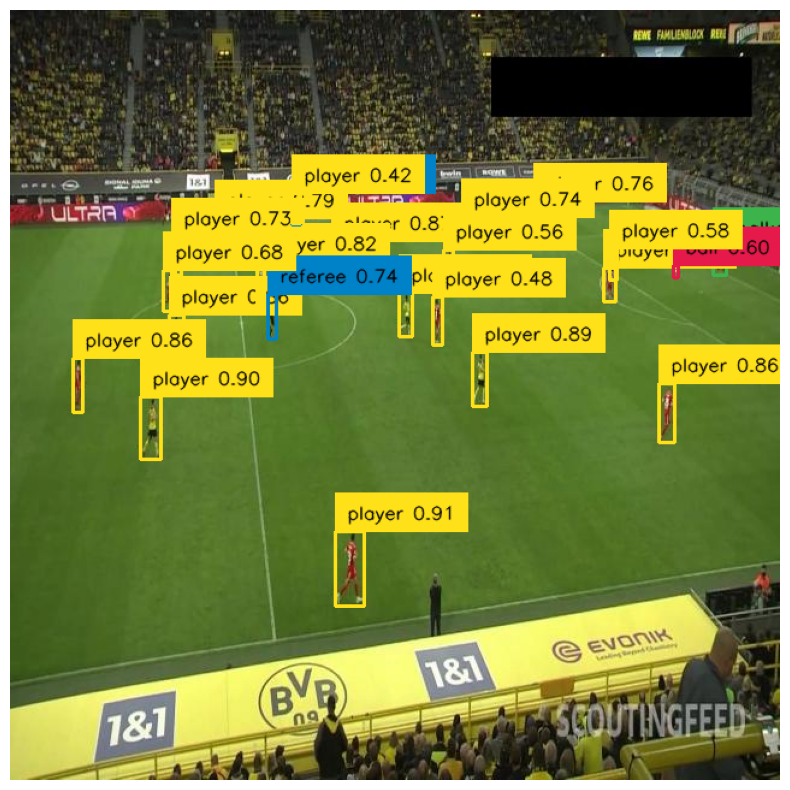

In [60]:
image = random.choice(images)
result = inference_detector(model, image)
detections = sv.Detections.from_mmdetection(result)
detections = detections[detections.confidence > 0.4].with_nms()

box_annotator = sv.BoxAnnotator()
labels = [
    f"{ds.classes[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in detections
]
annotated_image = box_annotator.annotate(image.copy(), detections, labels=labels)
sv.plot_image(image=annotated_image, size=(10, 10))

## Use `supervision` to evaluate trained RTMDet model

In [51]:
CONFIDENCE_THRESHOLD = 0.35
NMS_IOU_THRESHOLD = 0.7

### Load test dataset with `supervision`

In [58]:
ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

print('dataset classes:', ds.classes)
print('dataset size:', len(ds))

dataset classes: ['ball', 'goalkeeper', 'player', 'referee']
dataset size: 13


### Calculate confusion matrix

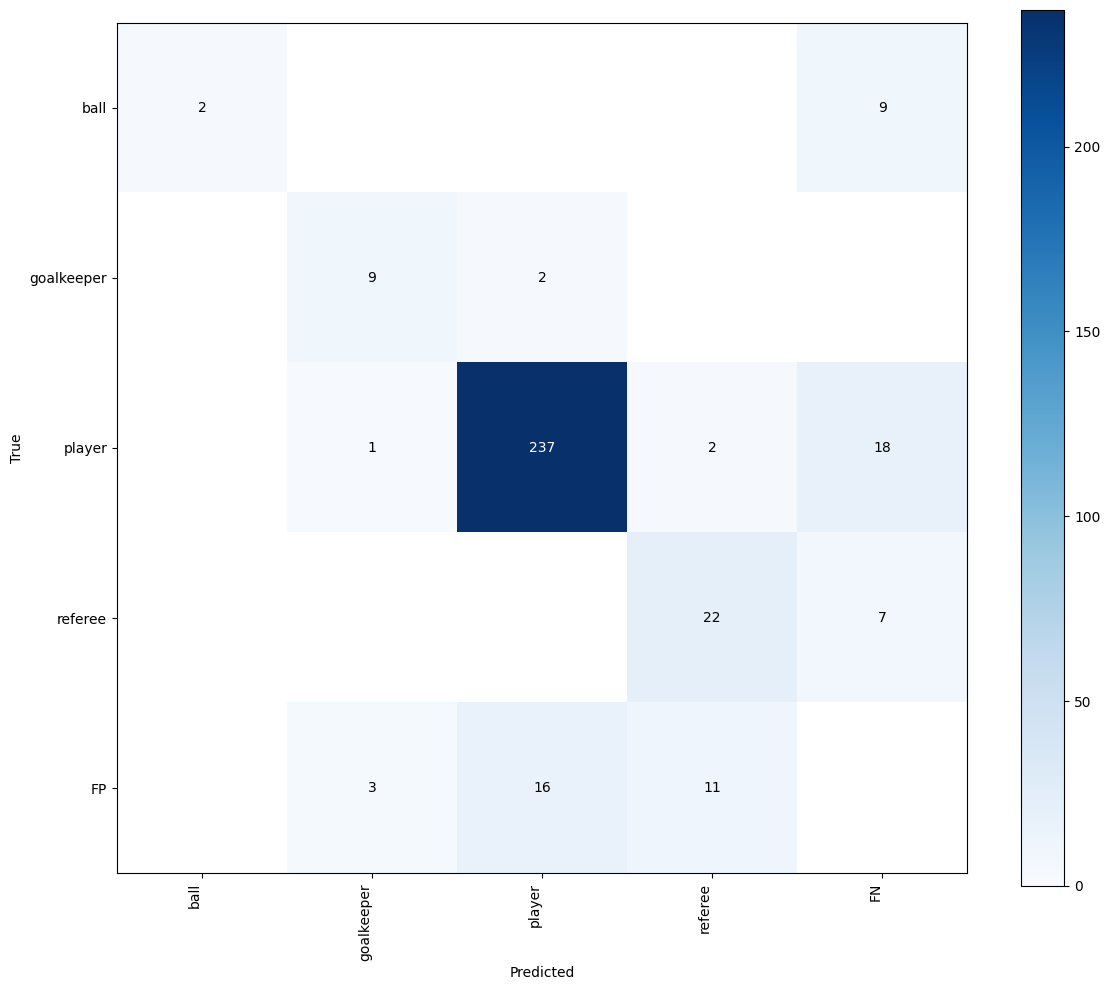

In [59]:
def callback(image: np.ndarray) -> sv.Detections:
    result = inference_detector(model, image)
    detections = sv.Detections.from_mmdetection(result)
    return detections[detections.confidence > CONFIDENCE_THRESHOLD].with_nms(threshold=NMS_IOU_THRESHOLD)


confusion_matrix = sv.ConfusionMatrix.benchmark(
    dataset = ds,
    callback = callback
)

_ = confusion_matrix.plot()

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.